In [3]:
import numpy as np, pandas as pd
import scipy.stats as stat
import sklearn as sk
import pandas_profiling
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
house_info = pd.read_csv("House_Prices.csv")

In [5]:
house_info.shape

(128, 8)

In [6]:
house_info.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [7]:
#Detailed profiling using pandas profiling

pandas_profiling.ProfileReport(house_info)

In [8]:
dict(house_info.dtypes)

{'Home': dtype('int64'),
 'Price': dtype('int64'),
 'SqFt': dtype('int64'),
 'Bedrooms': dtype('int64'),
 'Bathrooms': dtype('int64'),
 'Offers': dtype('int64'),
 'Brick': dtype('O'),
 'Neighborhood': dtype('O')}

In [9]:
numeric_var_names=[key for key in dict(house_info.dtypes) if dict(house_info.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(house_info.dtypes) if dict(house_info.dtypes)[key] in ['object', 'O']]

In [10]:
print(numeric_var_names)

['Home', 'Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers']


In [11]:
print(cat_var_names)

['Brick', 'Neighborhood']


In [12]:
house_info_num=house_info[numeric_var_names]
house_info_num.head(5)

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers
0,1,114300,1790,2,2,2
1,2,114200,2030,4,2,3
2,3,114800,1740,3,2,1
3,4,94700,1980,3,2,3
4,5,119800,2130,3,3,3


In [13]:
house_info_cat=house_info[cat_var_names]
house_info_cat.head(5)

,Brick,Neighborhood
0,No,East
1,No,East
2,No,East
3,No,East
4,No,East


#### Creating Data audit Report

In [14]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.std()/x.mean(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [15]:
num_var_summary = house_info_num.apply(var_summary).T
num_var_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,CV,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Home,128.0,0.0,8256.0,64.500000,64.5,37.094474,1.376000e+03,0.575108,1.0,2.27,7.35,13.7,32.75,64.5,96.25,115.3,121.65,126.73,128.0
Price,128.0,0.0,16694700.0,130427.343750,125950.0,26868.770371,7.219308e+08,0.206006,69100.0,81570.00,91310.00,102020.0,111325.00,125950.0,148250.00,166560.0,179465.00,196476.00,211200.0
SqFt,128.0,0.0,256120.0,2000.937500,2000.0,211.572431,4.476289e+04,0.105737,1450.0,1530.80,1664.00,1720.0,1880.00,2000.0,2140.00,2250.0,2368.00,2505.70,2590.0
Bedrooms,128.0,0.0,387.0,3.023438,3.0,0.725951,5.270054e-01,0.240108,2.0,2.00,2.00,2.0,3.00,3.0,3.00,4.0,4.00,4.73,5.0
Bathrooms,128.0,0.0,313.0,2.445312,2.0,0.514492,2.647023e-01,0.210399,2.0,2.00,2.00,2.0,2.00,2.0,3.00,3.0,3.00,3.00,4.0
Offers,128.0,0.0,330.0,2.578125,3.0,1.069324,1.143455e+00,0.414768,1.0,1.00,1.00,1.0,2.00,3.0,3.00,4.0,4.00,5.00,6.0


In [16]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=house_info_cat.apply(cat_summary)

In [17]:
cat_summary

,Brick,Neighborhood
N,128,128
NMISS,0,0
ColumnsNames,"No 86 Yes 42 Name: Brick, dtype: int64",East 45 North 44 West 39 Name: Neig...


In [18]:
#Handling Outliers 
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

house_info_num=house_info_num.apply(outlier_capping)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


In [19]:
num_var_summary = house_info_num.apply(var_summary).T
num_var_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,CV,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Home,128.0,0.0,8256.00,64.500000,64.5,37.053408,1.372955e+03,0.574471,2.27,2.4671,7.35,13.7,32.75,64.5,96.25,115.3,121.65,126.5329,126.73
Price,128.0,0.0,16689692.00,130388.218750,125950.0,26280.461229,6.906626e+08,0.201555,81570.00,81767.1000,91310.00,102020.0,111325.00,125950.0,148250.00,166560.0,179465.00,194268.4800,196476.00
SqFt,128.0,0.0,256103.00,2000.804688,2000.0,207.625863,4.310850e+04,0.103771,1530.80,1538.6840,1664.00,1720.0,1880.00,2000.0,2140.00,2250.0,2368.00,2487.9610,2505.70
Bedrooms,128.0,0.0,386.46,3.019219,3.0,0.715071,5.113269e-01,0.236840,2.00,2.0000,2.00,2.0,3.00,3.0,3.00,4.0,4.00,4.5329,4.73
Bathrooms,128.0,0.0,312.00,2.437500,2.0,0.498028,2.480315e-01,0.204319,2.00,2.0000,2.00,2.0,2.00,2.0,3.00,3.0,3.00,3.0000,3.00
Offers,128.0,0.0,329.00,2.570312,3.0,1.047559,1.097379e+00,0.407561,1.00,1.0000,1.00,1.0,2.00,3.0,3.00,4.0,4.00,5.0000,5.00


In [20]:
house_info_num.isna().sum()

Home         0
Price        0
SqFt         0
Bedrooms     0
Bathrooms    0
Offers       0
dtype: int64

In [21]:
# create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [22]:
house_info_cat.columns

Index(['Brick', 'Neighborhood'], dtype='object')

In [23]:
# Feature selection

for c_feature in ['Brick', 'Neighborhood']:
    house_info_cat[c_feature] = house_info_cat[c_feature].astype('category')
    house_info_cat = create_dummies(house_info_cat , c_feature )

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [24]:
house_info_cat.head()

,Brick_Yes,Neighborhood_North,Neighborhood_West
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [25]:
house_info_new = pd.concat([house_info_num, house_info_cat], axis=1)

In [26]:
house_info_new.columns

Index(['Home', 'Price', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick_Yes',
       'Neighborhood_North', 'Neighborhood_West'],
      dtype='object')

In [27]:
house_info_new.shape

(128, 9)

In [28]:
house_info_new.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West
0,2.27,114300,1790.0,2.0,2,2,0,0,0
1,2.27,114200,2030.0,4.0,2,3,0,0,0
2,3.00,114800,1740.0,3.0,2,1,0,0,0
3,4.00,94700,1980.0,3.0,2,3,0,0,0
4,5.00,119800,2130.0,3.0,3,3,0,0,0


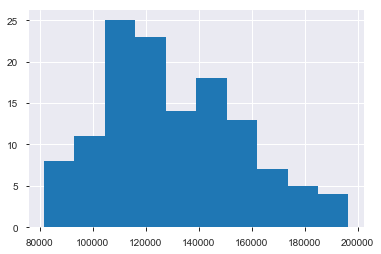

In [29]:
house_info_new.Price.hist()

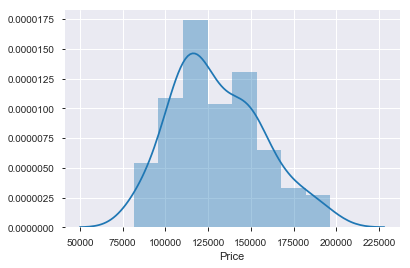

In [30]:
# Distribution of variables
sns.distplot(house_info_new.Price)

In [31]:
house_info_num.corr()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers
Home,1.000000,0.100964,0.174942,-0.071751,0.109003,-0.051830
Price,0.100964,1.000000,0.549070,0.523483,0.501744,-0.314728
SqFt,0.174942,0.549070,1.000000,0.481769,0.520577,0.338639
Bedrooms,-0.071751,0.523483,0.481769,1.000000,0.384359,0.119065
Bathrooms,0.109003,0.501744,0.520577,0.384359,1.000000,0.182055
Offers,-0.051830,-0.314728,0.338639,0.119065,0.182055,1.000000


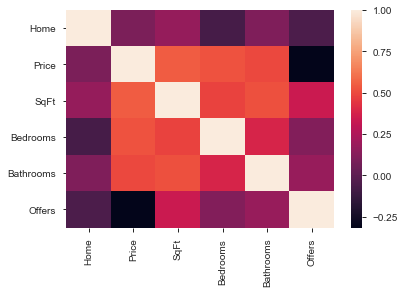

In [32]:
sns.heatmap(house_info_num.corr())

In [33]:
#Splitting the data

feature_columns = house_info_new.columns.difference( ['Price'] )
feature_columns

Index(['Bathrooms', 'Bedrooms', 'Brick_Yes', 'Home', 'Neighborhood_North',
       'Neighborhood_West', 'Offers', 'SqFt'],
      dtype='object')

In [34]:
train, test = train_test_split( house_info_new,test_size = 0.3,random_state = 1234 )

In [35]:
lm = smf.ols("Price~Bathrooms+Bedrooms+Brick_Yes+Neighborhood_West+Offers+SqFt", train).fit()

C:\Users\HP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [36]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     83.59
Date:                Tue, 17 Sep 2019   Prob (F-statistic):           7.67e-33
Time:                        18:55:33   Log-Likelihood:                -938.66
No. Observations:                  89   AIC:                             1891.
Df Residuals:                      82   BIC:                             1909.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2907.7781   1.02e+0

#### Mathematical equation:
Price = 2907.7781 + 7442.1183 * Bathrooms + 5207.7191 * Bedrooms + 1.642e+04 * Brick_Yes + 2.078e+04 * Neighborhood_West - 6966.2649 * Offers + 50.2328 * SqFt

In [37]:
train["pred_price"] = lm.predict(train)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test["pred_price"] = lm.predict(test)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
#Train Data
MAPE_train = np.mean(np.abs(train.Price - train.pred_price)/train.Price )
print(MAPE_train)


RMSE_train = mean_squared_error(train.Price , train.pred_price)
print(RMSE_train)

Corr_train = stat.stats.pearsonr(train.Price , train.pred_price)
print(Corr_train)


#Test Data
MAPE_test = np.mean(np.abs(test.Price - test.pred_price)/test.Price )
print(MAPE_test)

RMSE_test = mean_squared_error(test.Price , test.pred_price)
print(RMSE_test)

Corr_test = stat.stats.pearsonr(test.Price , test.pred_price)
print(Corr_test)

0.05854200536664614
84786556.98629762
(0.9270818555240317, 7.754006992538848e-39)
0.06866236429924073
105540166.65673064
(0.9427049222438476, 3.161126398283667e-19)


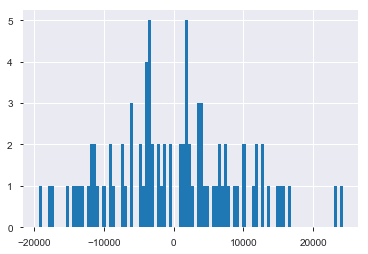

In [40]:
lm.resid.hist(bins=100)